# Binomial Distribution

$$\binom{n}{k} p^k (1-p)^{n-k}$$

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. `It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. `If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.’

“But [MacKay asks] do these data give evidence that the coin is biased rather than fair?”

$\binom{n}{k}$ is the binomial coefficient - "n choose k"

In [1]:
from empiricaldist import Pmf
from scipy.stats import binom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# If we flip one coin n=2 times and p(heads) is .5, what's the probability of getting k=1 heads?
n = 2
p = 0.5
k = 1
binom.pmf(k, n, p)

0.5000000000000002

In [3]:
# Set up an array of k values
ks = np.arange(n + 1)

# setup probabilities
ps = binom.pmf(ks, n, p)

# On 2 flips
# p(0 heads), p(1 head), p(2 heads)
ps

array([0.25, 0.5 , 0.25])

In [4]:
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [5]:
# This function computes the binomial distribution
# for given values of n and p 
# and returns a Pmf that represents the result.

def make_binomial(n, p):
    """Make a binomial Pmf"""
    ks = np.arange(n + 1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [6]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.head()

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71


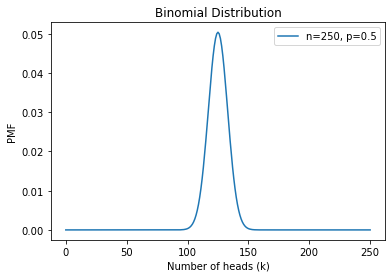

In [7]:
plt.title("Binomial Distribution")
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.plot(pmf_k, label="n=250, p=0.5");
plt.legend();

In [8]:
pmf_k.max_prob()

125

In [9]:
# p(exactkly 125 heads)
# pmf_k[125] different api, same results
pmf_k(125)

0.0504122131473097

In [10]:
pmf_k(140)

0.008357181724918204

In [11]:
# Out of 250 flips
# If we have a fair coin, what are the odds of flipping 140 heads?
n = 250
p = 0.5
k = 140
binom.pmf(k, n, p)

0.008357181724918204

> In the article MacKay quotes, the statistician says, “If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%.”



In [12]:
# We'll use the binomial distribution to check MacKay's math. 
# The following function takes a PMF and computes the total probability of quantities greater than or equal to threshold.

def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold"""
    ge = pmf.qs >= threshold
    total = pmf[ge].sum()
    return total

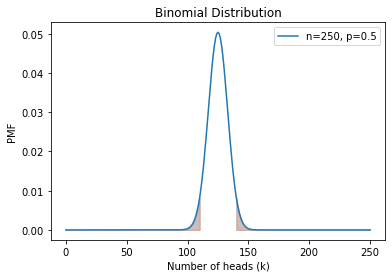

In [13]:
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index


fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])

pmf_k.plot(label='n=250, p=0.5')

plt.title("Binomial Distribution");
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.legend();

In [14]:
prob_ge(pmf_k, 140)

0.03321057562002169

In [15]:
pmf_k.prob_ge(140)

0.03321057562002169

# Bayesian Estimation
> Any given coin has some probability of landing heads up when spun on edge; I’ll call this probability x. It seems reasonable to believe that x depends on physical characteristics of the coin, like the distribution of weight. If a coin is perfectly balanced, we expect x to be close to 50%, but for a lopsided coin, x might be substantially different. We can use Bayes’s theorem and the observed data to estimate x.

**Estimate unknown probabilities!**

In [16]:
# For simplicity we start with a uniform prior (dig into this later)
# Uniform prior is rectangular, assuming all values of x are equally likely
# Here's an implementation of a uniform prior

# equal likelihoods of flipping 0% to 100% heads
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
prior.head()

,probs
0.00,1
0.01,1
0.02,1


In [17]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [18]:
likelihood = {
    "H": likelihood_heads,
    "T": likelihood_tails
}

In [19]:
# Let's represent the data as a string
dataset = "H" * 140 + "T" * 110
dataset[0:5]
len(dataset)

250

In [20]:
# The following function does the update.

def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [21]:
posterior = prior.copy()

In [22]:
update_euro(posterior, dataset)

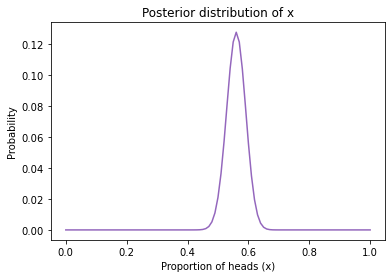

In [23]:
posterior.plot(label="140 heads out of 250", color="C4")
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability")
plt.title("Posterior distribution of x")
plt.show();

In [24]:
# If we get 140 heads out of 250
# we can estimate that the p(heads) is 56%
# (and assume uniform uncertainty)
# The 
posterior.max_prob()

0.56

## Triangle Prior

![triangle man](triangleman.jpeg)

In [25]:
# So far we’ve been using a uniform prior:

uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

It might be more reasonable to choose a prior that gives higher probability to values of x near 0.5 and lower probability to extreme values.

In [26]:
ramp_up = np.arange(50) # np.arange(0, 50, 1)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name="triangle")
triangle.normalize()

2500

Text(0, 0.5, 'Probability of heads')

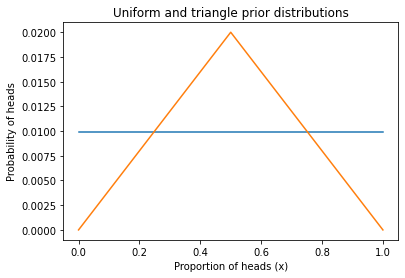

In [27]:
uniform.plot();
triangle.plot();
plt.title("Uniform and triangle prior distributions");
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability of heads")

In [28]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

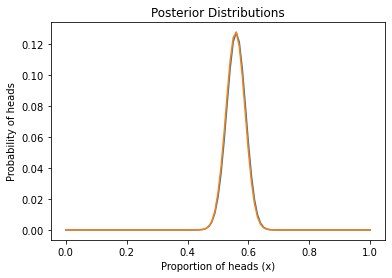

In [29]:
# Plot the updated priors
# The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

uniform.plot()
triangle.plot()

plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability of heads")
plt.title("Posterior Distributions");

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

And that’s good news. To see why, imagine two people who disagree angrily about which prior is better, uniform or triangle. Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.

But suppose they agree to use the data to update their beliefs. When they compare their posterior distributions, they find that there is almost nothing left to argue about.

This is an example of swamping the priors: with enough data, people who start with different priors will tend to converge on the same posterior distribution.

**Ultimately, updating our beliefs with data matters more than our priors**

(this sounds logical and easy, but is conceptually chalenging, as we'll see shortly)

$$\binom{n}{k} p^k (1-p)^{n-k}$$

In [30]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [31]:
# The data are represented with a tuple of values for k and n, rather than a long string of outcomes. Here’s the update.
uniform2 = Pmf(1, hypos, name="uniform2")
data = 140, 250
update_binomial(uniform2, data)

In [32]:
np.allclose(uniform, uniform2)

True

The 101 Bowls and Euro problem are very similar. 
- The prior distributions are the same. 
- The prior likelihoods are the same
- And w/ the same data, the results would be the same
- But there's more to it

The 101 Bowls problem contained a uniform distribution in the setup, so that make sense.

With the Euro problem, the choice of priors is subjective.

And because the priors are subjective, the posteriors are subjective, too. And some people find that problematic.

In the 101 Bowls problem, we choose the bowl randomly, so it is uncontroversial to compute the probability of choosing each bowl. In the Euro problem, the proportion of heads is a physical property of a given coin. Under some interpretations of probability, that’s a problem because physical properties are not considered random.

Under the Bayesian interpretation of probability, it is meaningful and useful to treat physical quantities as if they were random and compute probabilities about them.

In the Euro problem, the prior distribution represents what we believe about coins in general and the posterior distribution represents what we believe about a particular coin after seeing the data. So we can use the posterior distribution to compute probabilities about the coin and its proportion of heads.

The subjectivity of the prior and the interpretation of the posterior are key differences between using Bayes’s Theorem and doing Bayesian statistics.



## Exercise

In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

For this exercise, I’ll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

In [33]:
# Here's the uniform prior
# I imagine the range of .1 to .4 is to create a bounds for the .2 to .33 likelihoods
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [34]:
likelihood = {
    "Y": hypos,
    "N": 1 - hypos
}

In [35]:
# Here’s a dataset that yields a reasonable prior distribution.
# I'm not in love with this approach (yet)
# This sets up someone batting 0.25
# I'm not sure where this batting 0.25 came from since it's not in the problem setup
dataset = "Y" * 25 + "N" * 75

In [36]:
# Update the uniform prior with the data
for data in dataset:
    prior *= likelihood[data]

prior.normalize()

1.3596964206970507e-23

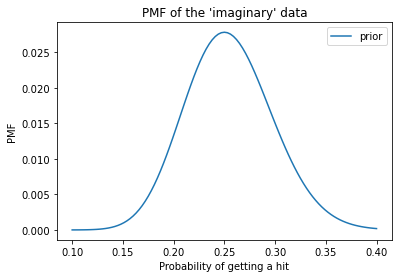

In [37]:
prior.plot(label='prior')
plt.title("PMF of the 'imaginary' data")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();

*Thought* Since we "proved" that priors don't matter as much as the data we use to update our beliefs, then this batting 0.25 assumption makes a bit more sense.

This does feel arbitrary, however.

In [38]:
# Now update the distribution with the data and plot the posterior. What is the most likely quantity in the posterior distribution?

# Solution

posterior = prior.copy()

for data in 'YYY':
    posterior *= likelihood[data]

posterior.normalize()

0.017944179687707326

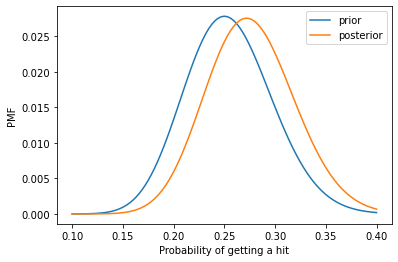

In [39]:
# Solution
prior.plot(label="prior")
posterior.plot(label="posterior")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();

In [40]:
prior.max_prob(), posterior.max_prob()

(0.25, 0.271)

## 5 hits in a row

"Posterior's max probability is 0.28600000000000003"

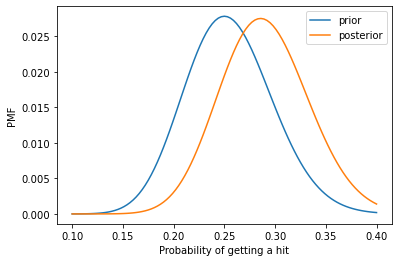

In [41]:
# But what about updating the priors with hitting 20 balls in a row?
posterior = prior.copy()

for data in 'Y' * 5:
    posterior *= likelihood[data]

posterior.normalize()

# Solution
prior.plot(label="prior")
posterior.plot(label="posterior")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();
f"Posterior's max probability is {posterior.max_prob()}"

## 20 hits in a row

"Posterior's max probability is 0.376"

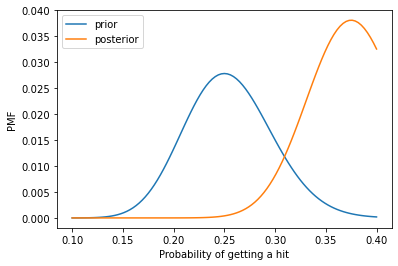

In [42]:
# But what about updating the priors with hitting 20 balls in a row?
posterior = prior.copy()

for data in 'Y' * 20:
    posterior *= likelihood[data]

posterior.normalize()

# Solution
prior.plot(label="prior")
posterior.plot(label="posterior")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();
f"Posterior's max probability is {posterior.max_prob()}"

In [43]:
posterior.index[0:5]

Float64Index([0.1, 0.10300000000000001, 0.10600000000000001,
              0.10900000000000001, 0.112],
             dtype='float64')

In [44]:
posterior.values[0:5]

array([4.23582819e-16, 1.24697707e-15, 3.53043301e-15, 9.63319470e-15,
       2.53824525e-14])

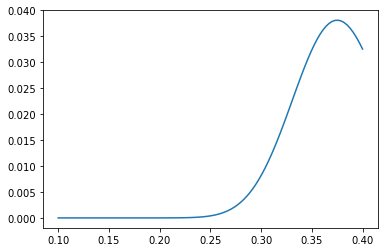

In [45]:
plt.plot(posterior.index, posterior.values)

In [46]:
prior.max_prob(), posterior.max_prob()

(0.25, 0.376)

Takeaways:
- If someone hits 20 balls in a row, they highest likelihood for that outcome is if they batted .319?
- Is that what that signifies?
- Since this is about probability simulation using new data, that seems to track. 

## Exercise
Exercise: Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. One way to improve the accuracy of the results is randomized response.

As an example, suppose you want to know how many people cheat on their taxes. If you ask them directly, it is likely that some of the cheaters will lie. You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

If they get heads, they report YES.

If they get tails, they honestly answer the question “Do you cheat on your taxes?”

If someone says YES, we don’t know whether they actually cheat on their taxes; they might have flipped heads. Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs. Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes? What is the most likely quantity in the posterior distribution?

In [47]:
# Setting up a uniform prior distribution (there could be more information that would informa. different prior, but this is good enough)
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [48]:
# If the actual fraction of cheaters is `x`, then the number of
# YESs is 0(.5 + x/2) and the number of NOs is (1-x) / 2
likelihood = {
    "Y": 0.5 + hypos/2,
    "N": (1 - hypos) / 2
}

In [49]:
# Here’s a dataset that yields a reasonable prior distribution.
# I'm not in love with this approach (yet)
# This sets up someone batting 0.25
# I'm not sure where this batting 0.25 came from since it's not in the problem setup
dataset = "Y" * 80 + "N" * 20

In [50]:
posterior = prior.copy()
for data in dataset:
    posterior *= likelihood[data]

posterior.normalize()

3.6945139133967024e-21

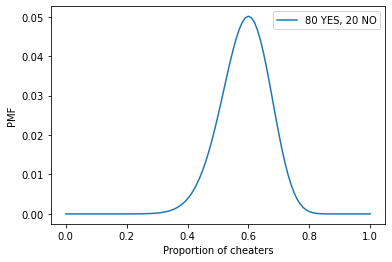

In [51]:
posterior.plot(label="80 YES, 20 NO")
plt.xlabel("Proportion of cheaters")
plt.ylabel("PMF")
plt.legend()
plt.plot();

## Exercise
Exercise: Suppose you want to test whether a coin is fair, but you don’t want to spin it hundreds of times. So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate. Specifically, suppose the probability is y=0.2 that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of x? What happens as you vary the value of y?

In [52]:
# Update beliefs but add some unreliability in the system from y
def update_unreliable(pmf, dataset, y):
    
    likelihood = {
        "H": (1 - y) * hypos + y * (1 - hypos),
        "T": y * hypos + (1 - y) * (1 - hypos)
    }
    
    for data in dataset:
        pmf *= likelihood[data]
    
    pmf.normalize()

In [53]:
# solution
# Setup a prior. It's uniform
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
dataset = "H" * 140 + "T" * 110

In [54]:
# Set up 3 scenarios

# No unreliability
posterior00 = prior.copy()
update_unreliable(posterior00, dataset, 0.0)

# 20% unreliability of y
posterior02 = prior.copy()
update_unreliable(posterior02, dataset, 0.2)

# 40% unreliability of y
posterior04 = prior.copy()
update_unreliable(posterior04, dataset, 0.4)

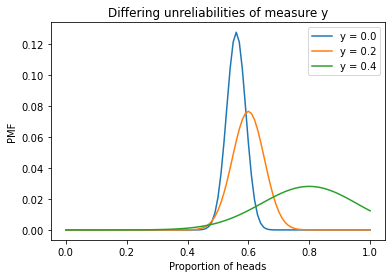

In [55]:
# Solution

posterior00.plot(label='y = 0.0')
posterior02.plot(label='y = 0.2')
posterior04.plot(label='y = 0.4')
plt.title("Differing unreliabilities of measure y")
plt.xlabel('Proportion of heads')
plt.ylabel('PMF')
plt.legend()
plt.show();

In [56]:
# Solution

posterior00.idxmax(), posterior02.idxmax(), posterior04.idxmax()

(0.56, 0.6, 0.8)

## Exercise
Exercise: In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders. Of course, some missile designs are better than others; let’s assume that each design has some probability of hitting an alien ship, x.

Based on previous tests, the distribution of x in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested. In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test. The results of the test are confidential, so the general won’t say how many targets were hit, but they report: “The same number of targets were hit in the two tests, so we have reason to think this new design is consistent.”

Is this data good or bad? That is, does it increase or decrease your estimate of x for the Alien Blaster 9000?

Hint: If the probability of hitting each target is 𝑥, the probability of hitting one target in both tests is [2𝑥(1−𝑥)]2.

In [57]:
# Setup
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [58]:

# Here's a specific version for n=2 shots per test

x = hypos
likes = [(1-x)**4, (2*x*(1-x))**2, x**4]
likelihood = np.sum(likes, axis=0)

In [59]:
# Solution

# Here's a more general version for any n shots per test

from scipy.stats import binom

n = 2
likes2 = [binom.pmf(k, n, x)**2 for k in range(n+1)]
likelihood2 = np.sum(likes2, axis=0)

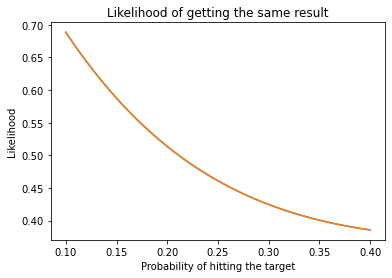

In [60]:

# Here are the likelihoods, computed both ways

import matplotlib.pyplot as plt

plt.plot(x, likelihood, label='special case')
plt.plot(x, likelihood2, label='general formula')
plt.xlabel('Probability of hitting the target')
plt.ylabel('Likelihood')
plt.title('Likelihood of getting the same result')
plt.show();

In [61]:
posterior = prior * likelihood
posterior.normalize()

49.129627998379995

(0.0, 0.015)

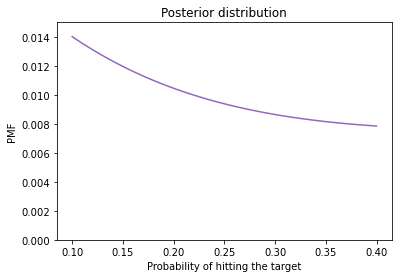

In [62]:
posterior.plot(label='Two tests, two shots, same outcome',
               color='C4')
plt.xlabel('Probability of hitting the target')
plt.ylabel('PMF')
plt.title('Posterior distribution')
plt.ylim(0, 0.015)

In [63]:
# Solution

# Getting the same result in both tests is more likely for 
# extreme values of `x` and least likely when `x=0.5`.

# In this example, the prior indicates that `x` is less than 0.5,
# and the update gives more weight to extreme values.

# So the dataset makes lower values of `x` more likely.